In [1]:
!pip install transformers

     |████████████████████████████████| 1.3MB 12.4MB/s 
     |████████████████████████████████| 2.9MB 51.5MB/s 
     |████████████████████████████████| 1.1MB 48.3MB/s 
     |████████████████████████████████| 890kB 52.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=e87dc41031241f793dbe67f0a01d87b8b1899b5446b8c44b15d106938bfe1bad
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [21]:
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn import functional as F
from transformers import AdamW
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences

In [22]:
if torch.cuda.is_available():   
   device = torch.device("cuda")
   print('Using GPU ', torch.cuda.get_device_name(0))
else:
   device = torch.device("cpu")
   print('Using CPU')

Using GPU  Tesla T4


In [24]:
df = pd.read_csv('train.csv')

In [25]:
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [26]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
df['a_l'] = LE.fit_transform(df['author'])

In [27]:
df.head()

,id,text,author,a_l
0,id26305,"This process, however, afforded me no means of...",EAP,0
1,id17569,It never once occurred to me that the fumbling...,HPL,1
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,0
3,id27763,How lovely is spring As we looked from Windsor...,MWS,2
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,1


In [28]:
df['text'] = df['text'].apply(lambda x: x.lower())

In [29]:
X_data = df['text'].values
X_data

array(['this process, however, afforded me no means of ascertaining the dimensions of my dungeon; as i might make its circuit, and return to the point whence i set out, without being aware of the fact; so perfectly uniform seemed the wall.',
       'it never once occurred to me that the fumbling might be a mere mistake.',
       'in his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.',
       ...,
       'mais il faut agir that is to say, a frenchman never faints outright.',
       'for an item of news like this, it strikes us it was very coolly received."',
       'he laid a gnarled claw on my shoulder, and it seemed to me that its shaking was not altogether that of mirth.'],
      dtype=object)

In [30]:
y_label = df['a_l'].values
y_label

array([0, 1, 0, ..., 0, 0, 1])

In [31]:
class_to_int = {"EAP" : 0, "HPL" : 1, "MWS" : 2}
int_to_class = {0 : "EAP", 1 : "HPL", 2 : "MWS"}

In [32]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', return_dict=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [33]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
for sent in X_data:
    encoded_sent = tokenizer.encode(sent,add_special_tokens = True)
    input_ids.append(encoded_sent)

Token indices sequence length is longer than the specified maximum sequence length for this model (955 > 512). Running this sequence through the model will result in indexing errors


In [34]:
# Print sentence 0, now as a list of IDs.
print('Original: ', X_data[0])
print('Token IDs:', input_ids[0])

Original:  this process, however, afforded me no means of ascertaining the dimensions of my dungeon; as i might make its circuit, and return to the point whence i set out, without being aware of the fact; so perfectly uniform seemed the wall.
Token IDs: [101, 2023, 2832, 1010, 2174, 1010, 22891, 2033, 2053, 2965, 1997, 2004, 17119, 18249, 2075, 1996, 9646, 1997, 2026, 16633, 1025, 2004, 1045, 2453, 2191, 2049, 4984, 1010, 1998, 2709, 2000, 1996, 2391, 2043, 3401, 1045, 2275, 2041, 1010, 2302, 2108, 5204, 1997, 1996, 2755, 1025, 2061, 6669, 6375, 2790, 1996, 2813, 1012, 102]


In [35]:
input_ids = pad_sequences(input_ids, maxlen=20, dtype="long",value=0, truncating="post", padding="post")

In [36]:
X_train, X_test, y_train, y_test = train_test_split(input_ids, y_label,shuffle=True,test_size=0.20,random_state=42,stratify=y_label)

In [37]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
count_misclassified = (y_test != y_pred).sum()
count_misclassified


2290

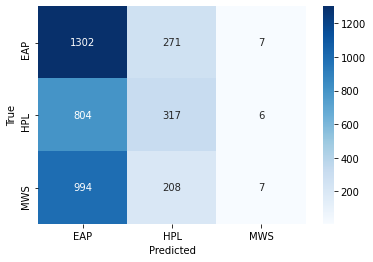

[0.55641026 0.32969319 0.01139138]


In [38]:
class_names = ['EAP','HPL','MWS']
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels())
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels())
plt.ylabel('True')
plt.xlabel('Predicted');
plt.show()

print(f1_score(y_test,y_pred,average=None))